### Annotation Selection of the hg38 genome

##### Before you begin, please make sure you have the proper files downloaded

In [1]:
#Download link for gencode annotation file (gff3): https://www.gencodegenes.org/human/release_38.html
##Make sure to download the "comprehensive gene annotation file" in the gff3 format

# ! wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gff3.gz

#Download link for hg38 archetype motif file: https://www.vierstra.org/resources/motif_clustering
##Download the hg38 archetype scan file alongside its tabix file
# ! wget https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.all_motifs.v1.0.bed.gz
# ! wget https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.all_motifs.v1.0.bed.gz.tbi

In [1]:
import pandas as pd
import numpy as np
import gffutils
import pysam

##### If this is your first time importing the gff3 database, run this command

In [2]:
#This can take a long time, so only run this once (remove the #)

gencode_hg38_annotation_gff3 = '/home/michalula/code/Ella/data/hg38/gencode.v38.annotation.gff3'
gencode_hg38_annotation_path = '/home/michalula/code/Ella/data/hg38/gencode.v38.annotation.gff3db.db'


# db = gffutils.create_db(gencode_hg38_annotation_gff3, dbfn=gencode_hg38_annotation_path, 
#                         force=True, keep_order=True, 
#                         merge_strategy='create_unique', sort_attribute_values=True) 

#replace gff3 with your gff3 file, dbfn can be whichever name you want to store the transposed file as


##### Feature the selected database 

In [3]:
db = gffutils.FeatureDB(gencode_hg38_annotation_path, keep_order=True)
db

##### Select the desired range

In [4]:
chr = 'chr1' #Replace with wanted chromosome location
# start = 207320867 #Replace with start coordinate
# stop = 207320897 #Replace with end coordinate

# CG_#69:
# chr1:207,321,626-207,321,639
start = 207321626 # 207320867 #Replace with start coordinate
stop = 207321639 # 207320897 #Replace with end coordinate

# # CD55 TSS region within 180 bps
# start = 207321614 # 207320867 #Replace with start coordinate
# stop = 207321733 # 207320897 #Replace with end coordinate

slct = db.region(region=(chr, start, stop), completely_within=False)


##### Iterate through the region and transpose it to a dictionary

In [5]:
records = []
for gene in slct:
    records.append({
        "seqid": gene.seqid,
        "source": gene.source,
        "featuretype": gene.featuretype,
        "start": gene.start,
        "end": gene.end,
        "strand": gene.strand,
        "score": gene.score,
        "attributes": gene.attributes  # Attributes as a dictionary (will be expanded later)
    })

##### Next, lets integrate the cell-specific regulatory elements into this database:

In [6]:
input_file = '/home/michalula/code/Ella/data/hg38/hg38.all_motifs.v1.0.bed.gz'
# 'hg38.archetype_motifs.v1.0.bed.gz' #Replace with the RE file
tabix = pysam.TabixFile(input_file)
source_name = 'atlas' #replace with reference cell type
#It may say that the index file is older than the data file, you can ignore this for now

In [7]:
#Create dictionary using the input selection
for row in tabix.fetch(chr,start,stop):
    assets = row.split()
    records.append({
        "seqid": assets.pop(0),
        "source": source_name,
        "start": int(assets.pop(0)),
        "end": int(assets.pop(0)),
        "featuretype": 'RE',
        "strand": assets.pop(2),
        "attributes": ({"ID": assets.pop(2), "matchscore": float(assets.pop(1)), "cluster":assets.pop(0)})  # Attributes as a dictionary (will be expanded later)
    })

##### Expand out the attributes and format the dictionary as a database

In [8]:
df = pd.DataFrame(records)
attributes_df = df["attributes"].apply(pd.Series)
df = pd.concat([df.drop(columns=["attributes"]), attributes_df], axis=1)

display(df)

,seqid,source,featuretype,start,end,strand,score,ID,Parent,gene_id,...,level,protein_id,transcript_support_level,hgnc_id,tag,ccdsid,havana_gene,havana_transcript,matchscore,cluster
0,chr1,HAVANA,five_prime_UTR,207321532,207321765,+,.,[UTR5:ENST00000367063.6],[ENST00000367063.6],[ENSG00000196352.16],...,[2],[ENSP00000356030.2],[1],[HGNC:2665],"[basic, CCDS]",[CCDS73022.1],[OTTHUMG00000036255.7],[OTTHUMT00000088210.2],NaN,NaN
1,chr1,HAVANA,exon,207321532,207321865,+,.,[exon:ENST00000367063.6:1],[ENST00000367063.6],[ENSG00000196352.16],...,[2],[ENSP00000356030.2],[1],[HGNC:2665],"[basic, CCDS]",[CCDS73022.1],[OTTHUMG00000036255.7],[OTTHUMT00000088210.2],NaN,NaN
2,chr1,HAVANA,transcript,207321532,207340766,+,.,[ENST00000367063.6],[ENSG00000196352.16],[ENSG00000196352.16],...,[2],[ENSP00000356030.2],[1],[HGNC:2665],"[basic, CCDS]",[CCDS73022.1],[OTTHUMG00000036255.7],[OTTHUMT00000088210.2],NaN,NaN
3,chr1,HAVANA,gene,207321532,207386804,+,.,[ENSG00000196352.16],NaN,[ENSG00000196352.16],...,[1],NaN,NaN,[HGNC:2665],NaN,NaN,[OTTHUMG00000036255.7],NaN,NaN,NaN
4,chr1,atlas,RE,207321610,207321632,-,NaN,CGCAGAGCCCCAGCCCAGACCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.245709,SP2_HUMAN.H11MO.0.A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.867987,TFAP2A_TFAP_2
119,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.998108,TFAP2B_MA0812.1
120,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.998108,TFAP2B_TFAP_2
121,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.591858,TFAP2C_MA0814.1


##### Expand out the single list attributes as strings

In [9]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

display(df)

,seqid,source,featuretype,start,end,strand,score,ID,Parent,gene_id,...,level,protein_id,transcript_support_level,hgnc_id,tag,ccdsid,havana_gene,havana_transcript,matchscore,cluster
0,chr1,HAVANA,five_prime_UTR,207321532,207321765,+,.,UTR5:ENST00000367063.6,ENST00000367063.6,ENSG00000196352.16,...,2,ENSP00000356030.2,1,HGNC:2665,"[basic, CCDS]",CCDS73022.1,OTTHUMG00000036255.7,OTTHUMT00000088210.2,NaN,NaN
1,chr1,HAVANA,exon,207321532,207321865,+,.,exon:ENST00000367063.6:1,ENST00000367063.6,ENSG00000196352.16,...,2,ENSP00000356030.2,1,HGNC:2665,"[basic, CCDS]",CCDS73022.1,OTTHUMG00000036255.7,OTTHUMT00000088210.2,NaN,NaN
2,chr1,HAVANA,transcript,207321532,207340766,+,.,ENST00000367063.6,ENSG00000196352.16,ENSG00000196352.16,...,2,ENSP00000356030.2,1,HGNC:2665,"[basic, CCDS]",CCDS73022.1,OTTHUMG00000036255.7,OTTHUMT00000088210.2,NaN,NaN
3,chr1,HAVANA,gene,207321532,207386804,+,.,ENSG00000196352.16,NaN,ENSG00000196352.16,...,1,NaN,NaN,HGNC:2665,NaN,NaN,OTTHUMG00000036255.7,NaN,NaN,NaN
4,chr1,atlas,RE,207321610,207321632,-,NaN,CGCAGAGCCCCAGCCCAGACCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.245709,SP2_HUMAN.H11MO.0.A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.867987,TFAP2A_TFAP_2
119,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.998108,TFAP2B_MA0812.1
120,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.998108,TFAP2B_TFAP_2
121,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.591858,TFAP2C_MA0814.1


In [20]:
start - 207321532

94

In [23]:
stop - 207386804

-65165

In [10]:
df.columns 

Index(['seqid', 'source', 'featuretype', 'start', 'end', 'strand', 'score',
       'ID', 'Parent', 'gene_id', 'transcript_id', 'gene_type', 'gene_name',
       'transcript_type', 'transcript_name', 'exon_number', 'exon_id', 'level',
       'protein_id', 'transcript_support_level', 'hgnc_id', 'tag', 'ccdsid',
       'havana_gene', 'havana_transcript', 'matchscore', 'cluster'],
      dtype='object')

In [17]:
df[['gene_name']]

,gene_name
0,CD55
1,CD55
2,CD55
3,CD55
4,NaN
...,...
118,NaN
119,NaN
120,NaN
121,NaN


In [11]:
df[['cluster']]

,cluster
0,NaN
1,NaN
2,NaN
3,NaN
4,SP2_HUMAN.H11MO.0.A
...,...
118,TFAP2A_TFAP_2
119,TFAP2B_MA0812.1
120,TFAP2B_TFAP_2
121,TFAP2C_MA0814.1


In [12]:
df[['featuretype']] 

,featuretype
0,five_prime_UTR
1,exon
2,transcript
3,gene
4,RE
...,...
118,RE
119,RE
120,RE
121,RE


In [13]:
df['featuretype'] == 'RE'

0      False
1      False
2      False
3      False
4       True
       ...  
118     True
119     True
120     True
121     True
122     True
Name: featuretype, Length: 123, dtype: bool

In [14]:
RE_df = df[df['featuretype'] == 'RE']
RE_df

,seqid,source,featuretype,start,end,strand,score,ID,Parent,gene_id,...,level,protein_id,transcript_support_level,hgnc_id,tag,ccdsid,havana_gene,havana_transcript,matchscore,cluster
4,chr1,atlas,RE,207321610,207321632,-,NaN,CGCAGAGCCCCAGCCCAGACCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.245709,SP2_HUMAN.H11MO.0.A
5,chr1,atlas,RE,207321610,207321632,-,NaN,CGCAGAGCCCCAGCCCAGACCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.245709,SP2_MOUSE.H11MO.0.B
6,chr1,atlas,RE,207321611,207321633,-,NaN,GCAGAGCCCCAGCCCAGACCCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.003953,PATZ1_HUMAN.H11MO.0.C
7,chr1,atlas,RE,207321611,207321633,-,NaN,GCAGAGCCCCAGCCCAGACCCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.900288,SP2_HUMAN.H11MO.0.A
8,chr1,atlas,RE,207321611,207321633,-,NaN,GCAGAGCCCCAGCCCAGACCCC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.900288,SP2_MOUSE.H11MO.0.B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.867987,TFAP2A_TFAP_2
119,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.998108,TFAP2B_MA0812.1
120,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.998108,TFAP2B_TFAP_2
121,chr1,atlas,RE,207321632,207321643,+,NaN,CGCCCAAAGCA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.591858,TFAP2C_MA0814.1


In [15]:
RE_df['cluster']

4        SP2_HUMAN.H11MO.0.A
5        SP2_MOUSE.H11MO.0.B
6      PATZ1_HUMAN.H11MO.0.C
7        SP2_HUMAN.H11MO.0.A
8        SP2_MOUSE.H11MO.0.B
               ...          
118            TFAP2A_TFAP_2
119          TFAP2B_MA0812.1
120            TFAP2B_TFAP_2
121          TFAP2C_MA0814.1
122            TFAP2C_TFAP_2
Name: cluster, Length: 119, dtype: object

##### Use the following code to find an RE from the human genome browser

In [12]:
# lst_of_id = df[df["ID"] cluster== 'ZSCAN4_C2H2_1'] # 'ZFX_MOUSE.H11MO.0.B'] ##Replace with the RE ID
lst_of_id = df[df["cluster"] == 'ZSCAN4_C2H2_1'] # 'ZFX_MOUSE.H11MO.0.B'] ##Replace with the RE ID
lst_of_id.dropna(how='all', axis=1, inplace=True)
lst_of_id

/tmp/ipykernel_185712/968643798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lst_of_id.dropna(how='all', axis=1, inplace=True)


""


In [13]:
lst_of_id[lst_of_id['matchscore'] == 6.055805] #  7.7766] ###Replace with matchscore

KeyError: 'matchscore'

# Look at CD55 TSS
Hg38: chr1:207321614-207321733

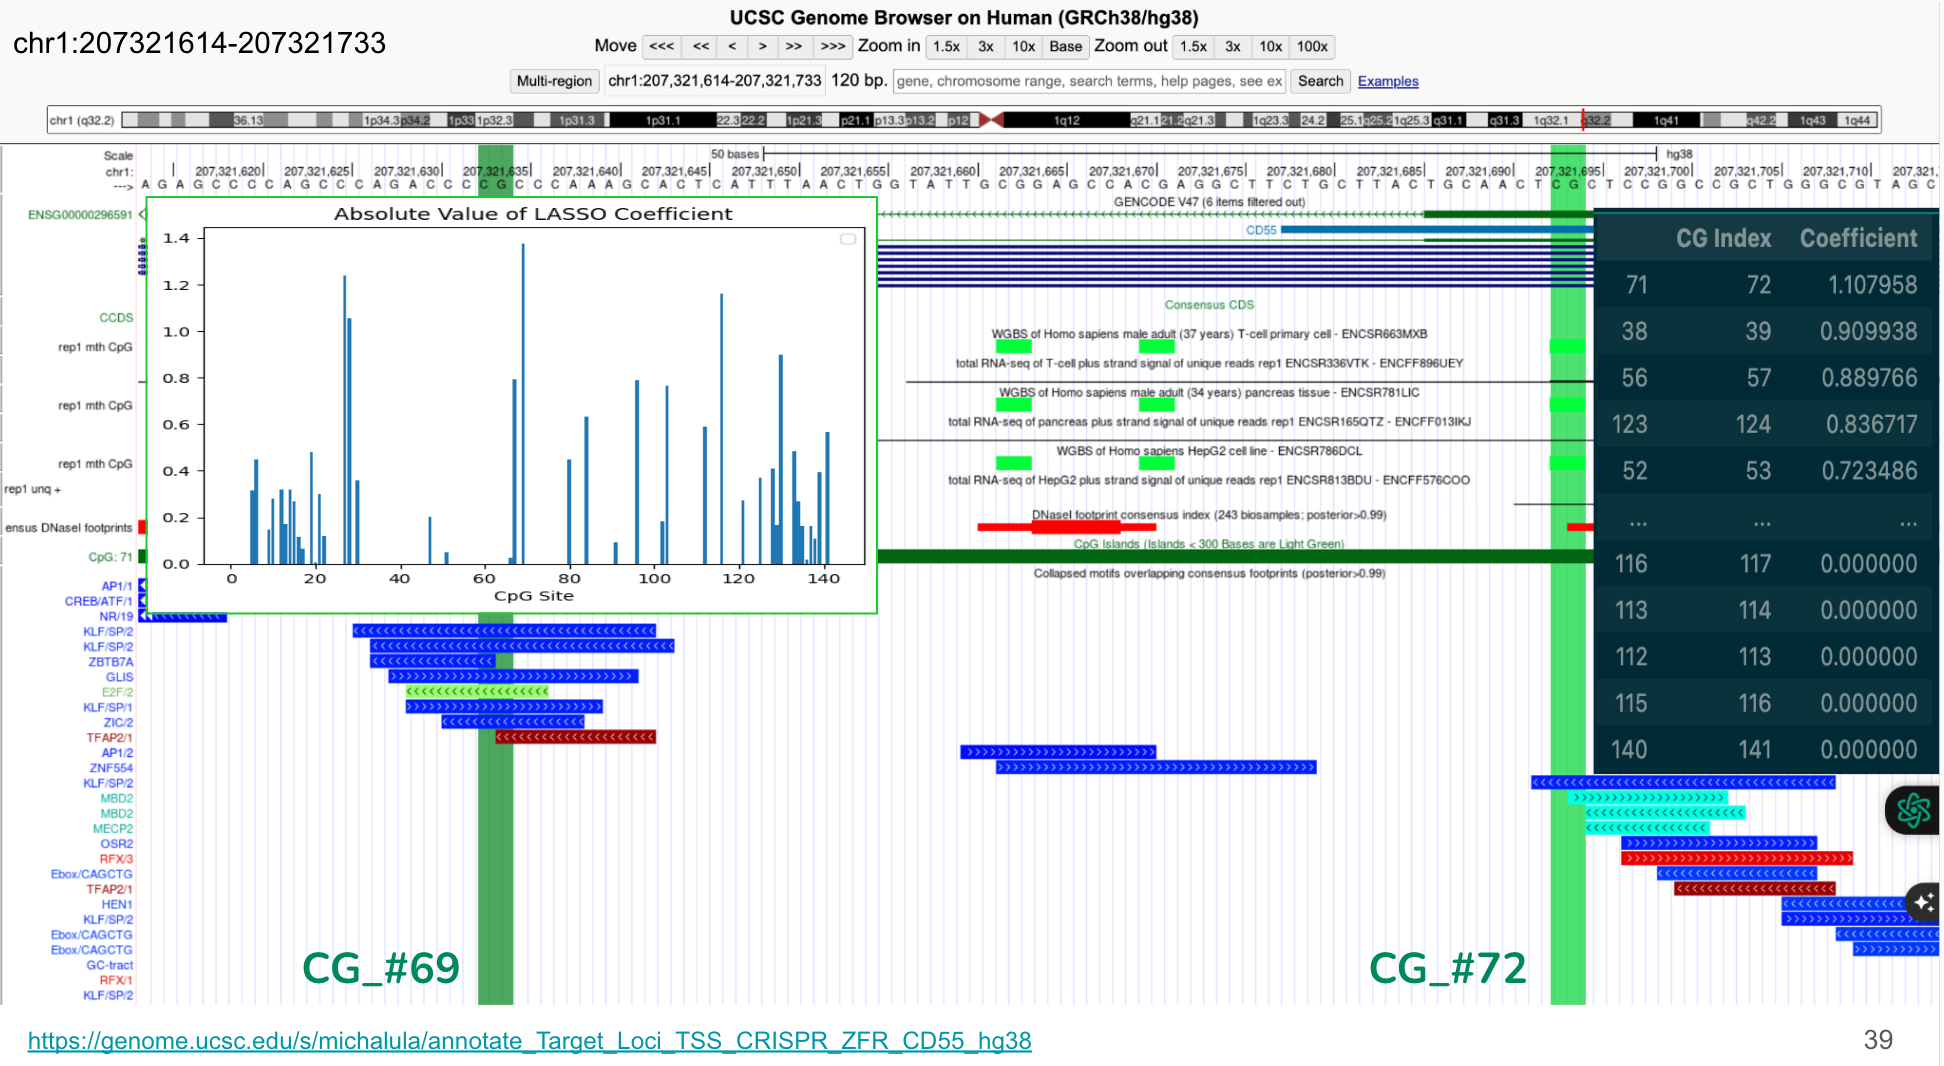

https://docs.google.com/presentation/d/1D3E_cHXUuQ8O-8w4-DlmNHy5SfraDWqwdF26uwxw0K8/edit?slide=id.g338a2d44f1a_0_89#slide=id.g338a2d44f1a_0_89 

# Liftover coordinates

### 1. Install LiftOver (if not already installed)


In [ ]:
# ! mkdir -p /home/michalula/software/liftOver
# ! wget -O /home/michalula/software/liftOver/liftOver http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/liftOver
# ! chmod +x /home/michalula/software/liftOver/liftOver
# ! export PATH="$PATH:/home/michalula/software/liftOver"
# ! source ~/.bashrc   # or ~/.zshrc
# ! head ~/.bashrc 

### 2. Get the chain file: hg38 to T2T-CHM13 v2.0 chain file:


In [ ]:
# As of now, UCSC does not officially support t2t-v2.0. However, the UCSC LiftOver chain file from hg38 to CHM13v2.0 is available from the CHM13 GitHub or NCBI FTP.

# Download it like this:
# ! wget -O /home/michalula/data/ref_genomes/liftOver/hg38ToHs1.over.chain.gz http://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHs1.over.chain.gz

# ! wget -O /home/michalula/data/ref_genomes/liftOver/hg38.chm13v2.chain.gz  https://s3.amazonaws.com/nanopore-human-wgs/chm13/liftover/hg38.chm13v2.chain.gz
# ! gunzip /home/michalula/data/ref_genomes/liftOver/hg38ToHs1.over.chain
# /home/michalula/data/ref_genomes/liftOver/hg38ToHs1.over.chain


gzip: /home/michalula/data/ref_genomes/liftOver/hg38ToHs1.over.chain.gz: No such file or directory


# 3. Prepare your BED file (hg38 coordinates)

Make sure your input file is in BED format, e.g.:

chr1    10000   10100

chr2    20000   20100

<!-- Save as input_hg38.bed to /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/hg38/hg38_liftover_test_input.bed -->

## LiftOver 
### from hg38 to T2T version2.0

In [31]:
# liftOver input_hg38.bed hg38.chm13v2.chain output_chm13v2.bed unmapped.bed
! /home/michalula/software/liftOver/liftOver /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/hg38/hg38_liftover_test_input.bed /home/michalula/data/ref_genomes/liftOver/hg38ToHs1.over.chain  /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/hg38/output_to_chm13v2.bed /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/hg38/output_to_unmapped.bed

Reading liftover chains
Mapping coordinates


### from T2T version2.0 to hg38

In [32]:
# 1. Download the reverse chain file (T2T → hg38)
! wget -O /home/michalula/data/ref_genomes/liftOver/hs1ToHg38.over.chain.gz http://hgdownload.soe.ucsc.edu/goldenPath/hs1/liftOver/hs1ToHg38.over.chain.gz

--2025-03-31 05:56:00--  http://hgdownload.soe.ucsc.edu/goldenPath/hs1/liftOver/hs1ToHg38.over.chain.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882482 (2.7M) [application/x-gzip]
Saving to: ‘/home/michalula/data/ref_genomes/liftOver/hs1ToHg38.over.chain.gz’

/home/michalula/dat 100%[===================>]   2.75M  2.03MB/s    in 1.4s    

2025-03-31 05:56:01 (2.03 MB/s) - ‘/home/michalula/data/ref_genomes/liftOver/hs1ToHg38.over.chain.gz’ saved [2882482/2882482]



In [34]:
%%bash

/home/michalula/software/liftOver/liftOver \
    /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/t2t_v2_0/t2tv2_test_input.bed \
    /home/michalula/data/ref_genomes/liftOver/hs1ToHg38.over.chain.gz \
    /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/t2t_v2_0/output_hg38_fromt2tv2_test.bed \
     /home/michalula/code/epiCausality/epiCode/genome_annotations/bed_files/t2t_v2_0/unmapped_hg38_fromt2tv2_test.bed 

Reading liftover chains
Mapping coordinates
